In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


In [ ]:
import os
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Input, GlobalAveragePooling2D, Dropout, add, SeparableConv2D, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.layers import concatenate, Activation

seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from my_utils.dataloader import load_data, load_pkl_data, load_csv_metadata, append_dict, split_train_val_iq
from my_utils.pre_processor import data_preprocess
from my_utils.metric import stats, feature_viewer

In [ ]:
training_path = 'gdrive/My Drive/Data/MAFAT RADAR Challenge - Training Set V1'
synthetic_path = 'gdrive/My Drive/Data/MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
experiment_path = 'gdrive/My Drive/Data/MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
private_path = 'gdrive/My Drive/Data/Phase 2 - Private/MAFAT RADAR Challenge - FULL Public Test Set V1'

In [ ]:
training_set_df = load_data(training_path)
synthetic_set_df = load_data(synthetic_path)
experiment_set_df = load_data(experiment_path)
private_set_df = load_data(private_path)

In [ ]:
df = append_dict(training_set_df, experiment_set_df)
df = append_dict(df, synthetic_set_df)
df = append_dict(df, private_set_df)
df = data_preprocess(df)

In [ ]:
train_x, train_y, val_x, val_y = split_train_val_iq(df)

In [ ]:
np.save('train_x.npy',train_x)
np.save('train_y.npy',train_y)
np.save('val_x.npy',val_x)
np.save('val_y.npy',val_y)

In [ ]:
train_x = np.load('train_x.npy', allow_pickle = True)
train_y = np.load('train_y.npy',  allow_pickle = True)

from imblearn.over_sampling import SMOTE

flattened_train_exp_x = []
for sample in train_x:
    flattened_train_exp_x.append(sample.flatten())
flattened_train_exp_x = np.asarray(flattened_train_exp_x)

smote_resampler = SMOTE(random_state = 0)
X_res_train, y_res_train = smote_resampler.fit_resample(flattened_train_exp_x, train_y)
np.save('train_x.npy', X_res_train)
np.save('train_y.npy', y_res_train)

In [ ]:
train_x = np.load('train_x.npy')
x_1 = []
for sample in train_x:
    m = sample.reshape(126, 32)
    x_1.append(m)
x_1 = np.asarray(x_1)
np.save('train_x.npy', x_1)

val_x = np.load('val_x.npy')
x_1 = []
for sample in val_x:
    m = sample.reshape(126, 32)
    x_1.append(m)
x_1 = np.asarray(x_1)
np.save('val_x.npy', x_1)

In [ ]:
train_x = np.load('train_x.npy', allow_pickle = True)
train_y = np.load('train_y.npy', allow_pickle = True)
val_x = np.load('val_x.npy', allow_pickle = True)
val_y = np.load('val_y.npy', allow_pickle = True)

val_y = val_y.astype(int)
train_y = train_y.astype(int)
train_x = train_x.reshape(list(train_x.shape) + [1])
val_x = val_x.reshape(list(val_x.shape) + [1])
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

(198086, 126, 32, 1) (198086,) (538, 126, 32, 1) (538,)


In [ ]:
def create_model(input_shape):

  loss_function = BinaryCrossentropy()
  optimizer = Adam(learning_rate = 0.00001)
  init = GlorotNormal(seed = 0)
  
  inputs = Input(shape = input_shape)

  x = Conv2D(32, 3, activation = 'relu', kernel_initializer = init, bias_regularizer = 'l2')(inputs)
  x = Conv2D(64, 3, activation = 'relu', kernel_initializer = init, bias_regularizer = 'l2')(x)
  block_1_output = MaxPooling2D(3)(x)

  x = Conv2D(64, 3, activation = 'relu', padding = "same", kernel_initializer = init, bias_regularizer = 'l2')(block_1_output)
  x = Conv2D(64, 3, activation = 'relu', padding = "same", kernel_initializer = init, bias_regularizer = 'l2')(x)
  block_2_output = add([x, block_1_output])

  x = Conv2D(64, 3, activation = 'relu', padding = "same", kernel_initializer = init, bias_regularizer = 'l2')(block_2_output)
  x = Conv2D(64, 3, activation = 'relu', padding = "same", kernel_initializer = init, bias_regularizer = 'l2')(x)
  block_3_output = add([x, block_2_output])

  x = Conv2D(64, 3, activation = 'relu', padding = "same", kernel_initializer = init, bias_regularizer = 'l2')(block_3_output)
  x = Conv2D(64, 3, activation = 'relu', padding = "same", kernel_initializer = init, bias_regularizer = 'l2')(x)
  block_4_output = add([x, block_3_output])

  x = Conv2D(64, 3, activation = 'relu', kernel_initializer = init, bias_regularizer = 'l2')(block_4_output)
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation = 'relu', kernel_initializer = init, bias_regularizer = 'l2')(x)

  outputs = Dense(1, activation = 'sigmoid', kernel_initializer = init)(x)

  model = Model(inputs, outputs)

  model.compile(loss = loss_function, optimizer = optimizer, metrics = [AUC(), 'accuracy'])
  model.summary()

  return model

In [ ]:
no_epochs = 100
batch_size = 64

img_width, img_height = 126, 32
input_shape = (img_width, img_height, 1)

model = create_model(input_shape)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 126, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 30, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 122, 28, 64)  18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 9, 64)    0           conv2d_1[0][0]                   
_______________________________________________________________________________________

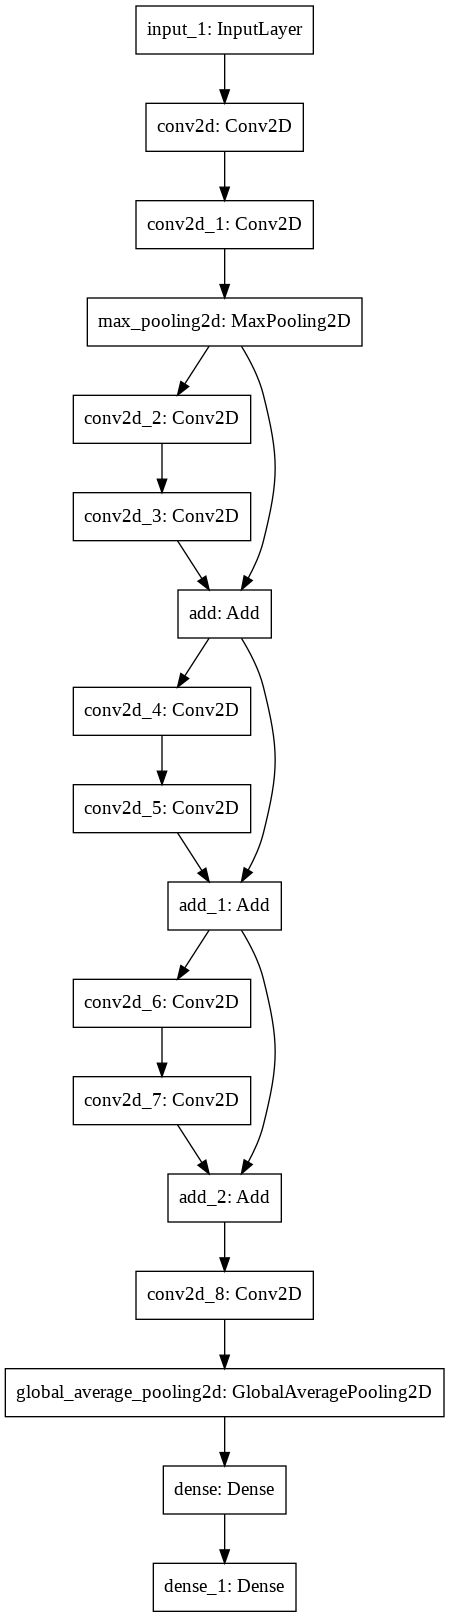

In [ ]:
plot_model(model)

In [ ]:
checkpoint_filepath = '/content/gdrive/My Drive/weights.hdf5'

model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = False, monitor = 'val_auc', mode = 'max', save_best_only = True)

model.fit(train_x, train_y, batch_size = batch_size, epochs = no_epochs, validation_data = (val_x, val_y), callbacks = [model_checkpoint_callback], use_multiprocessing = True)

Epoch 1/100
3096/3096 [==============================] - 66s 21ms/step - loss: 0.2710 - auc: 0.9574 - accuracy: 0.8783 - val_loss: 0.5993 - val_auc: 0.7912 - val_accuracy: 0.7193
Epoch 2/100
3096/3096 [==============================] - 65s 21ms/step - loss: 0.1501 - auc: 0.9865 - accuracy: 0.9422 - val_loss: 0.6390 - val_auc: 0.8148 - val_accuracy: 0.7119
Epoch 3/100
3096/3096 [==============================] - 65s 21ms/step - loss: 0.1281 - auc: 0.9900 - accuracy: 0.9507 - val_loss: 0.5460 - val_auc: 0.8310 - val_accuracy: 0.7454
Epoch 4/100
3096/3096 [==============================] - 66s 21ms/step - loss: 0.1130 - auc: 0.9921 - accuracy: 0.9569 - val_loss: 0.5652 - val_auc: 0.8387 - val_accuracy: 0.7472
Epoch 5/100
3096/3096 [==============================] - 65s 21ms/step - loss: 0.1033 - auc: 0.9933 - accuracy: 0.9603 - val_loss: 0.5887 - val_auc: 0.8454 - val_accuracy: 0.7286
Epoch 6/100
3096/3096 [==============================] - 65s 21ms/step - loss: 0.0970 - auc: 0.9940 - acc

In [ ]:
checkpoint_filepath = '/content/gdrive/My Drive/weights.hdf5'
model.load_weights(checkpoint_filepath)

In [ ]:
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

In [ ]:
test_path = 'gdrive/My Drive/Data/Phase 2 - Private/MAFAT RADAR Challenge - Private Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape) + [1])

import pandas as pd
submission = pd.DataFrame()

submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

In [ ]:
feature_viewer(model, val_x[0])

In [ ]:
submission.to_csv('submission.csv', index = False)

from zipfile import ZipFile

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')